In [7]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F

group_number = 3
train_path = f'../../data_preprocess/dataset/{group_number}/train.csv'
valid_path = f'../../data_preprocess/dataset/{group_number}/valid.csv'
test_path = f'../../translation/0.result/{group_number}/test_p.csv'
output_path = f'0.class_document/bert/{group_number}/test_p_c.csv'

train_data = pd.read_csv(train_path)
valid_data = pd.read_csv(valid_path)
test_data = pd.read_csv(test_path)

train_data['thing_property'] = train_data['thing'] + '_' + train_data['property']
valid_data['thing_property'] = valid_data['thing'] + '_' + valid_data['property']
test_data['thing_property'] = test_data['thing'] + '_' + test_data['property']


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder = LabelEncoder()
label_encoder.fit(train_data['thing_property'])

valid_data['thing_property'] = valid_data['thing_property'].apply(
    lambda x: x if x in label_encoder.classes_ else 'unknown_label')
test_data['thing_property'] = test_data['thing_property'].apply(
    lambda x: x if x in label_encoder.classes_ else 'unknown_label')

label_encoder.classes_ = np.append(label_encoder.classes_, 'unknown_label')

train_data['label'] = label_encoder.transform(train_data['thing_property'])
valid_data['label'] = label_encoder.transform(valid_data['thing_property'])
test_data['label'] = label_encoder.transform(test_data['thing_property'])

train_texts, train_labels = train_data['tag_description'], train_data['label']
valid_texts, valid_labels = valid_data['tag_description'], valid_data['label']

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors='pt')
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True, return_tensors='pt')

train_labels = torch.tensor(train_labels.values)
valid_labels = torch.tensor(valid_labels.values)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
valid_dataset = CustomDataset(valid_encodings, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_data['thing_property'].unique()))
optimizer = AdamW(model.parameters(), lr=3e-5)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 80
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")

    # 검증 루프
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    valid_accuracy = correct / total
    print(f'Validation Accuracy after Epoch {epoch + 1}: {valid_accuracy * 100:.2f}%')

# Test 데이터 예측 및 c_thing, c_property 추가
test_encodings = tokenizer(list(test_data['tag_description']), truncation=True, padding=True, return_tensors='pt')
test_dataset = CustomDataset(test_encodings, torch.zeros(len(test_data)))  

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predicted_thing_properties = []
predicted_scores = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        softmax_scores = F.softmax(outputs.logits, dim=-1)
        predictions = torch.argmax(softmax_scores, dim=-1)
        predicted_thing_properties.extend(predictions.cpu().numpy())
        predicted_scores.extend(softmax_scores[range(len(predictions)), predictions].cpu().numpy())

predicted_thing_property_labels = label_encoder.inverse_transform(predicted_thing_properties)

test_data['c_thing'] = [x.split('_')[0] for x in predicted_thing_property_labels]
test_data['c_property'] = [x.split('_')[1] for x in predicted_thing_property_labels]
test_data['c_score'] = predicted_scores

test_data['cthing_correct'] = test_data['thing'] == test_data['c_thing']
test_data['cproperty_correct'] = test_data['property'] == test_data['c_property']
test_data['ctp_correct'] = test_data['cthing_correct'] & test_data['cproperty_correct']

mdm_true_count = len(test_data[test_data['MDM'] == True])
accuracy = (test_data['ctp_correct'].sum() / mdm_true_count) * 100

print(f"Accuracy (MDM=True) for Group {group_number}: {accuracy:.2f}%")

test_data.to_csv(output_path, index=False)
print(f'Results saved to {output_path}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hwang/anaconda3/envs/torch/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 completed. Loss: 5.812545299530029
Validation Accuracy after Epoch 1: 2.20%
Epoch 2 completed. Loss: 5.4337921142578125
Validation Accuracy after Epoch 2: 12.22%
Epoch 3 completed. Loss: 4.7191081047058105
Validation Accuracy after Epoch 3: 18.78%
Epoch 4 completed. Loss: 3.5866851806640625
Validation Accuracy after Epoch 4: 27.73%
Epoch 5 completed. Loss: 2.891603469848633
Validation Accuracy after Epoch 5: 40.61%
Epoch 6 completed. Loss: 3.5778417587280273
Validation Accuracy after Epoch 6: 50.07%
Epoch 7 completed. Loss: 2.8838517665863037
Validation Accuracy after Epoch 7: 64.50%
Epoch 8 completed. Loss: 1.2843190431594849
Validation Accuracy after Epoch 8: 69.37%
Epoch 9 completed. Loss: 2.803881883621216
Validation Accuracy after Epoch 9: 76.16%
Epoch 10 completed. Loss: 1.6859067678451538
Validation Accuracy after Epoch 10: 77.75%
Epoch 11 completed. Loss: 1.5909239053726196
Validation Accuracy after Epoch 11: 80.19%
Epoch 12 completed. Loss: 3.397331953048706
Validation

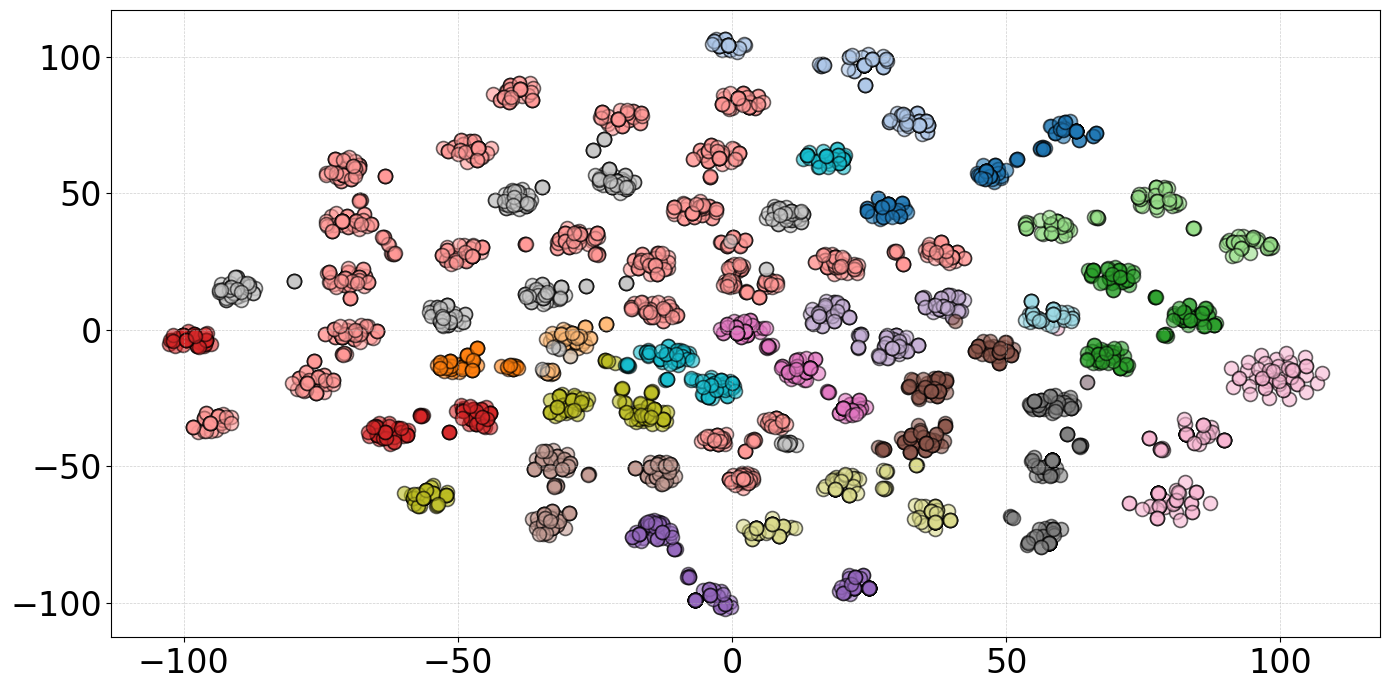

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 'filtered_data_plot.csv' 읽기
filtered_data = pd.read_csv('filtered_data_plot.csv')

# 데이터 토큰화
filtered_encodings = tokenizer(list(filtered_data['tag_description']), truncation=True, padding=True, return_tensors='pt')

# BERT 임베딩 계산 함수
def get_bert_embeddings(model, encodings, device):
    model.eval()
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # 각 문장의 평균 임베딩 추출

# BERT 모델로 임베딩 계산
bert_embeddings = get_bert_embeddings(model, filtered_encodings, device)

# t-SNE 차원 축소
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(bert_embeddings)

# 시각화를 위한 준비
unique_patterns = filtered_data['pattern'].unique()
color_map = plt.get_cmap('tab20', len(unique_patterns))
pattern_to_color = {pattern: idx for idx, pattern in enumerate(unique_patterns)}

plt.figure(figsize=(14, 7))

# 각 패턴별로 시각화
for pattern, color_idx in pattern_to_color.items():
    pattern_indices = filtered_data['pattern'] == pattern
    plt.scatter(tsne_results[pattern_indices, 0], tsne_results[pattern_indices, 1], 
                color=color_map(color_idx), marker='o', s=100, alpha=0.6, edgecolor='k', linewidth=1.2)

# 그래프 설정
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()
